<H1>step-by-step dataset preprocessing pipeline ⛵</H1>

✨ Summary of Preprocessing Steps<br/>
1️⃣ Load and convert audio files<br/>
2️⃣ Remove noise<br/>
3️⃣ Perform speaker diarization (to separate interviewer and child)<br/>
4️⃣ Transcribe speech (using Whisper or Wav2Vec2)<br/>
5️⃣ Extract speech features (thinking time, speech rate, WH question confusion, etc.)<br/>
6️⃣ Visualize data (graphs for better understanding)<br/>



<H2>🔹 Step 1: Install Dependencies</H2>

In [ ]:
!pip install librosa noisereduce pydub torch torchaudio transformers datasets matplotlib pandas pyannote.audio openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

<H2>🔹 Step 2: Mount Google Drive & Import Libraries</H2>

In [ ]:
from google.colab import drive
import os
import librosa
import noisereduce as nr
import torchaudio
import torchaudio.transforms as T
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.audio import Model
from transformers import pipeline
import whisper
import glob



In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define dataset folder paths
DATASET_PATH = "/content/drive/MyDrive/Research_audio_dataset"
POSITIVE_FOLDER = os.path.join(DATASET_PATH, "positive")
NEGATIVE_FOLDER = os.path.join(DATASET_PATH, "/content/drive/MyDrive/Research_audio_dataset/negative ")


<H2>🔹 Step 3: Convert MP3 to WAV & Remove Noise </H3>

**🔹 What This Code Does**<br/>
✔ Loops through all MP3 files inside positive/ and negative/ folders<br/>
✔ Converts MP3 → WAV at 16kHz (required for speech models)<br/>
✔ Removes background noise using noisereduce<br/>
✔ Saves cleaned WAV files inside a processed/ subfolder<br/>

In [ ]:
# Function to convert MP3 to WAV & remove noise
def convert_and_denoise(input_path, output_path):
    """ Load MP3, convert to WAV, remove noise, and save """
    print(f"Processing: {input_path}")
    y, sr = librosa.load(input_path, sr=16000)  # Load with 16kHz sampling rate
    reduced_noise = nr.reduce_noise(y=y, sr=sr)  # Noise reduction
    sf.write(output_path, reduced_noise, sr)  # Save cleaned audio
    print(f"✅ Saved cleaned audio: {output_path}")

In [ ]:
# Process all MP3 files in both positive & negative folders
for category in ["positive"]:
    folder_path = os.path.join(DATASET_PATH, category)  # Folder path
    output_folder = os.path.join(folder_path, "processed")  # New processed folder
    os.makedirs(output_folder, exist_ok=True)  # Create processed folder if not exists

    # Loop through all MP3 files in the folder (Corrected indentation)
    for file in glob.glob(os.path.join(folder_path, "*.mp3")):
        filename = os.path.basename(file).replace(".mp3", ".wav")  # Change extension
        output_file = os.path.join(output_folder, filename)  # Define output path
        convert_and_denoise(file, output_file)  # Process file

print("🎉 All audio files processed successfully!")

Processing: /content/drive/MyDrive/Research_audio_dataset/positive/audio1.mp3
✅ Saved cleaned audio: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio1.wav
Processing: /content/drive/MyDrive/Research_audio_dataset/positive/audio2.mp3
✅ Saved cleaned audio: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio2.wav
Processing: /content/drive/MyDrive/Research_audio_dataset/positive/audio3.mp3
✅ Saved cleaned audio: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio3.wav
Processing: /content/drive/MyDrive/Research_audio_dataset/positive/audio4.mp3
✅ Saved cleaned audio: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio4.wav
Processing: /content/drive/MyDrive/Research_audio_dataset/positive/audio5.mp3
✅ Saved cleaned audio: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio5.wav
Processing: /content/drive/MyDrive/Research_audio_dataset/positive/audio6.mp3
✅ Saved cleaned audio: /content/drive

In [ ]:
# Process all MP3 files in both positive & negative folders
for category in [NEGATIVE_FOLDER]:

    output_folder = os.path.join(folder_path, "processed")  # New processed folder
    os.makedirs(output_folder, exist_ok=True)  # Create processed folder if not exists

    # Loop through all MP3 files in the folder (Corrected indentation)
    for file in glob.glob(os.path.join(folder_path, "*.mp3")):
        filename = os.path.basename(file).replace(".mp3", ".wav")  # Change extension
        output_file = os.path.join(output_folder, filename)  # Define output path
        convert_and_denoise(file, output_file)  # Process file

print("🎉 All audio files processed successfully!")

🎉 All audio files processed successfully!


<H2>🔹 Step 4: Speaker Diarization & Transcription</H2>

Now we will:<br/>
1️⃣ Perform Speaker Diarization (separate interviewer vs. child)<br/>
2️⃣ Transcribe Speech (convert audio to text)<br/>

✅ Pre requisits: Authenticate with Hugging Face in Colab<br/>
🔹 Step 1: Get Your Hugging Face Access Token<br/>
* Go to Hugging Face Tokens<br/>
* Click "New Token"<br/>
* Set Role = Write<br/>
* Copy the generated token





**🔹 Step 2: Log in to Hugging Face in Google Colab**<br/>


In [ ]:
from huggingface_hub import login
login("your token")


✅ Step 1: Speaker Diarization (Separate Speakers)<br/>
This step identifies and labels who is speaking (child vs. interviewer).

In [ ]:
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.audio import Model

# Load the diarization pipeline with authentication
pipeline = SpeakerDiarization.from_pretrained("pyannote/speaker-diarization", use_auth_token="your token")

def perform_speaker_diarization(audio_path):
    """ Identify speakers in an audio file and return timestamped segments """
    print(f"Processing Speaker Diarization for: {audio_path}")

    diarization_result = pipeline({"uri": "audio_sample", "audio": audio_path})

    # Store diarization results
    diarization_data = []
    for segment, _, speaker in diarization_result.itertracks(yield_label=True):
        diarization_data.append([segment.start, segment.end, speaker])

    # Convert results to DataFrame
    df = pd.DataFrame(diarization_data, columns=["start_time", "end_time", "speaker"])
    return df


config.yaml:   0%|          | 0.00/500 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/318 [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cu124. Bad things might happen unless you revert torch to 1.x.


hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [ ]:
import os
from pyannote.audio.pipelines.speaker_diarization import SpeakerDiarization
from pyannote.core import Segment
import torch

# Load the diarization model
pipeline = SpeakerDiarization.from_pretrained("pyannote/speaker-diarization")
pipeline.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Define main folder paths
main_folder = "/content/drive/MyDrive/Research_audio_dataset"  # Change this to your actual folder path
positive_folder = os.path.join(main_folder, "positive", "processed")
negative_folder = os.path.join(main_folder, "negative", "processed")

# Ensure processed folders exist
os.makedirs(positive_folder, exist_ok=True)
os.makedirs(negative_folder, exist_ok=True)

def diarize_and_save(audio_path, output_folder):
    """Runs diarization on an audio file and saves the RTTM file in the correct folder."""
    diarization = pipeline(audio_path)

    # Generate output file path
    filename = os.path.basename(audio_path).replace(".wav", ".rttm")
    output_path = os.path.join(output_folder, filename)

    with open(output_path, "w") as f:
        for segment, _, speaker in diarization.itertracks(yield_label=True):
            f.write(f"{segment.start:.3f} {segment.end:.3f} {speaker}\n")

    print(f"✅ Diarization saved: {output_path}")

# Loop through both Positive and Negative Processed folders
for category in ["positive", "negative"]:
    processed_folder = os.path.join(main_folder, category, "processed")

    if not os.path.exists(processed_folder):
        print(f"⚠️ Folder missing: {processed_folder}")
        continue

    for file in os.listdir(processed_folder):
        if file.endswith(".wav"):  # Process only audio files
            audio_file_path = os.path.join(processed_folder, file)
            diarize_and_save(audio_file_path, processed_folder)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cu124. Bad things might happen unless you revert torch to 1.x.
✅ Diarization saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio1.rttm
✅ Diarization saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio3.rttm
✅ Diarization saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio8.rttm
✅ Diarization saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio4.rttm
✅ Diarization saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio6.rttm
✅ Diarization saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio2.rttm
✅ Diarization saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio9.rttm
✅ Diarization saved: /content/drive/MyDrive/Research_audio_dataset/

<h3>✅ Step 2: Speech-to-Text (Transcription)</h3>
We now convert the child’s responses into text using OpenAI Whisper.



In [ ]:
import whisper

# Load the Whisper model
model = whisper.load_model("base")

def transcribe_audio(audio_path):
    """ Convert speech to text """
    print(f"Transcribing: {audio_path}")
    result = model.transcribe(audio_path)
    return result["text"]

# Process all WAV files and transcribe
for category in ["positive", "negative"]:
    processed_folder = os.path.join("/content/drive/MyDrive/Research_audio_dataset", category, "processed")

    for file in glob.glob(os.path.join(processed_folder, "*.wav")):
        transcription = transcribe_audio(file)

        # Save transcriptions
        output_txt = file.replace(".wav", "_transcription.txt")
        with open(output_txt, "w") as f:
            f.write(transcription)
        print(f"✅ Transcription saved: {output_txt}")


100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 168MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio1.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio1_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio2.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio2_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio3.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio3_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio4.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio4_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio5.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio5_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio6.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio6_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio7.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio7_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio8.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio8_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio9.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio9_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio10.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio10_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio11.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio11_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio12.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio12_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio13.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio13_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio14.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio14_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio15.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio15_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio16.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio16_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio17.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio17_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio18.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio18_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio19.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio19_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/ausio20.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/ausio20_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio21.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio21_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio22.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio22_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio23.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio23_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio24.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio24_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio25.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio25_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio26.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio26_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio27.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio27_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio41.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio41_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio42.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio42_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio43.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio43_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio45.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio45_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio44.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio44_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio46.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio46_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio47.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio47_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio48.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio48_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio49.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio49_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio50.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio50_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio51.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio51_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio52.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio52_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio53.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio53_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio54.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio54_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio28.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio28_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio30.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio30_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio29.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio29_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio31.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio31_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio32.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio32_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio34.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio34_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio33.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio33_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio36.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio36_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio35.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio35_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio37.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio37_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio38.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio38_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio39.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio39_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio40.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio40_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio55.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio55_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio56.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio56_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio57.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio57_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio58.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio58_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio59.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio59_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio60.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio60_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio61.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio61_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio62.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio62_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio66.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio66_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio68.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio68_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio69.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio69_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio71.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio71_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio72.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio72_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio70.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio70_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio73.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio73_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio74.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio74_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio75.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio75_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio76.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio76_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio67.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio67_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio63.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio63_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio64.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio64_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio77.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio77_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio78.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio78_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio79.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio79_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio80.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio80_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio82.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio82_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio81.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio81_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio83.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio83_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio85.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio85_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio84.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio84_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio65.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio65_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio86.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio86_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio87.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio87_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio88.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio88_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio90.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio90_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio89.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio89_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio91.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio91_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio92.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio92_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio93.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio93_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio94.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio94_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio95.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio95_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio96.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio96_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio97.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio97_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio98.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio98_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio99.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio99_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio100.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio100_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio101.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio101_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio102.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio102_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio103.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio103_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio106.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio106_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio105.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio105_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio107.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio107_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio109.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio109_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio108.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio108_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio104.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio104_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audi110.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audi110_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio111.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio111_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio112.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio112_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio113.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio113_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio114.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio114_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio116.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio116_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio115.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio115_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio117.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio117_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio119.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio119_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio118.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio118_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio120.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio120_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio121.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio121_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio122.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio122_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio123.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio123_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio124.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio124_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio125.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio125_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio126.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio126_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio128.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio128_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio129.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio129_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio130.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio130_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio131.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio131_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio132.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio132_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio137.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio137_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio136.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio136_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/aydio135.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/aydio135_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio134.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio134_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio133.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio133_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio138.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio138_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio139.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio139_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio140.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio140_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio141.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio141_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio143.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio143_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio144.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio144_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio145.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio145_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio146.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio146_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio147.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio147_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio148.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio148_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio149.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio149_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio150.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio150_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio151.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio151_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio152.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio152_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio153.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio153_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio154.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio154_transcription.txt
Transcribing: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio155.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


✅ Transcription saved: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio155_transcription.txt


✅ Step 4: Extract Features from Speech<br/>
Now that we have:<br/>

Diarization Data (who spoke when)<br/>
Transcription Data (text from speech)<br/>

We will analyze the child’s speech:<br/>

🔹 Key Speech Features We Extract:<br/>
1️⃣ Thinking Time (⏳ Delay before answering)<br/>
2️⃣ Speech Rate (🗣️ Words per second)<br/>
3️⃣ WH-Question Confusion (❓ Misinterpretation of WH questions)<br/>
4️⃣ Pauses & Silence (🤔 Unusual gaps in speech)<br/>
5️⃣ Pitch & Tone Variations (📢 Emotional range in speech)<br/>


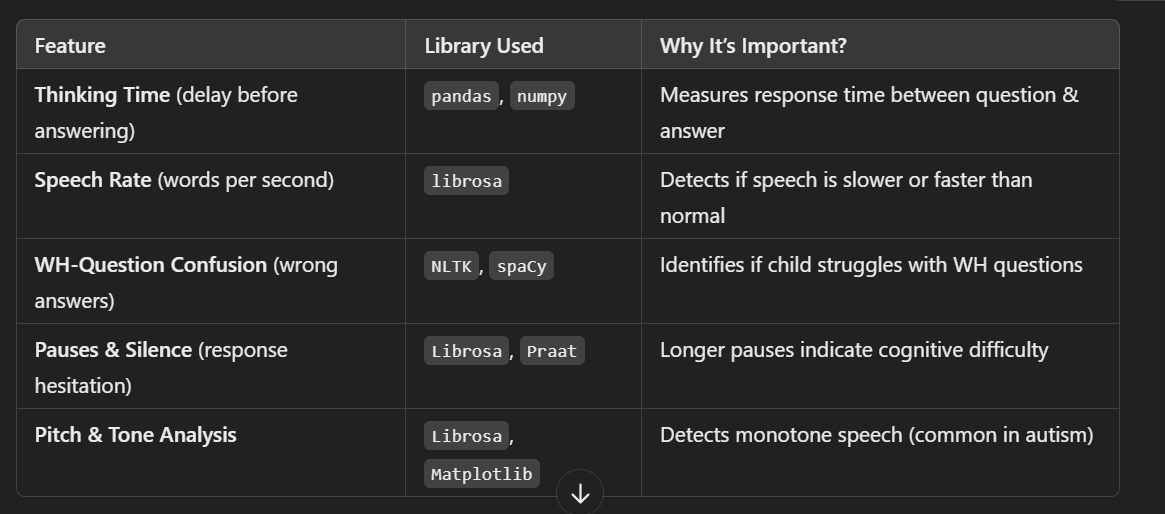


In [ ]:
from pydub import AudioSegment, silence
import torchaudio
import torch
from transformers import pipeline

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

<h3>Getting paths for (RTTM, TXT) files and audio files (.wav) are stored.</h3>

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/Research_audio_dataset/"  # Main folder containing all files
AUDIO_DIR = "/processed"     # Audio files are also stored here


<h3>parse RTTM diarization files</h3>

In [ ]:
def parse_rttm(rttm_path):
    timestamps = []

    with open(rttm_path, "r") as file:
        for line_num, line in enumerate(file, start=1):
            parts = line.strip().split()
            if len(parts) >= 8:  # Standard RTTM format
                try:
                    speaker = parts[7]
                    start_time = float(parts[3])
                    duration = float(parts[4])
                    end_time = start_time + duration
                    timestamps.append((speaker, start_time, end_time))
                except ValueError:
                    print(f"⚠️ Skipping malformed line {line_num} in {rttm_path}: {line}")
            else:
                print(f"⚠️ Skipping incorrect RTTM line: {line}")

    return timestamps

<h3>extract transcribed words</h3>

In [ ]:
# Function to extract transcribed words
def parse_transcription(txt_path):
    with open(txt_path, "r") as file:
        text = file.read().strip()
    return text, word_tokenize(text)   # Tokenized words for speech rate analysis

<h3> Extract Thinking Time ⏳</h3>

In [ ]:
# Thinking Time ⏳
def compute_thinking_time(rttm_data):
    interviewer_end = None
    thinking_times = []

    for speaker, start, end in rttm_data:
        print(f"🔍 Checking speaker: {speaker}, Start: {start}, End: {end}")  # Debugging output

        if "interviewer" in speaker.lower() or "SPEAKER_00" in speaker:
            interviewer_end = end
            print(f"🎙️ Interviewer spoke until: {interviewer_end}")

        elif "child" in speaker.lower() or "SPEAKER_01" in speaker:
            if interviewer_end is not None:
                thinking_time = start - interviewer_end
                if 0 < thinking_time < 10:  # Valid response delay (ignore too long gaps)
                    thinking_times.append(thinking_time)
                    print(f"⏳ Thinking time detected: {thinking_time} sec")
                interviewer_end = None  # Reset after child's response

    avg_thinking_time = np.mean(thinking_times) if thinking_times else 0
    print(f"✅ Final thinking time: {avg_thinking_time} sec\n")
    return avg_thinking_time


<h3>Extract Speech Rate (Words Per Second) 🗣️</h3>

In [ ]:
def compute_speech_rate(rttm_data, words):
    child_speech_duration = sum(end - start for speaker, start, end in rttm_data if "child" in speaker.lower() or "SPEAKER_01" in speaker)

    print(f"📏 Child's total speech duration: {child_speech_duration} sec")  # Debugging output
    print(f"📝 Total words spoken: {len(words)}")

    if child_speech_duration > 0:
        speech_rate = len(words) / child_speech_duration
        print(f"✅ Speech Rate: {speech_rate} words/sec\n")
        return speech_rate
    else:
        print(f"⚠️ No valid child speech duration found.\n")
        return 0

<h3>Identify WH-Question Confusion ❓</h3>

In [ ]:
import spacy

# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

def detect_wh_confusion(interviewer_text, child_text):
    """Detects if the child misinterprets WH-questions asked by the interviewer."""
    wh_words = {"who", "what", "where", "when", "why", "how"}

    interviewer_doc = nlp(interviewer_text)
    child_doc = nlp(child_text)


    # Check if interviewer asked a WH-question
    if any(token.text.lower() in wh_words for token in interviewer_doc):
        if len(child_doc) < 3:  # Child response is too short
            return True
        elif child_doc[0].text.lower() in {"yes", "no", "maybe"}:  # Child is confused
            return True

    return False


<h3>Extract Pauses & Silence 🤔</h3>

In [ ]:
def detect_silences(audio_path):
    audio = AudioSegment.from_wav(audio_path)
    silent_chunks = silence.detect_silence(audio, min_silence_len=2000, silence_thresh=-40)
    return len(silent_chunks), np.mean([end - start for start, end in silent_chunks]) if silent_chunks else 0

<h3> Extract Pitch & Tone Variations 📢</h3>

In [ ]:
def compute_pitch_variation(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    avg_pitch = np.nanmean(pitches[pitches > 0])
    return avg_pitch if not np.isnan(avg_pitch) else 0

<h2>Process all files</h2>

In [ ]:
# Process all files
results = []
for category in ["positive", "negative"]:
    rttm_folder = os.path.join(DATASET_DIR, category, "processed")

    print(f"\n🔍 Checking folder: {rttm_folder}")

    if not os.path.exists(rttm_folder):
        print(f"⚠️ Folder not found: {rttm_folder}")
        continue

    for file in os.listdir(rttm_folder):
        if file.endswith(".rttm"):
            file_id = file.replace(".rttm", "")
            rttm_path = os.path.join(rttm_folder, file)
            txt_path = os.path.join(rttm_folder, file_id + "_transcription.txt")
            audio_path = os.path.join(rttm_folder, file_id + ".wav")

            # Check if files exist
            if not os.path.exists(txt_path):
                print(f"⚠️ Missing transcription file: {txt_path}")
                continue
            if not os.path.exists(audio_path):
                print(f"⚠️ Missing audio file: {audio_path}")
                continue

            print(f"\n✅ Processing File ID: {file_id}")

            # Extract diarization and transcription data
            rttm_data = parse_rttm(rttm_path)
            transcription_text, words = parse_transcription(txt_path)

            print(f"📄 Transcription: {transcription_text[:100]}...")

            # Compute Features
            thinking_time = compute_thinking_time(rttm_data)
            speech_rate = compute_speech_rate(rttm_data, words)
            wh_confusion = detect_wh_confusion(transcription_text, transcription_text)
            silence_count, avg_silence = detect_silences(audio_path)
            avg_pitch = compute_pitch_variation(audio_path)

            print(f"⏳ Thinking Time: {thinking_time}")
            print(f"🗣️ Speech Rate: {speech_rate}")
            print(f"❓ WH Confusion: {wh_confusion}")
            print(f"🤔 Silence Count: {silence_count}, Avg Silence: {avg_silence}")
            print(f"📢 Avg Pitch: {avg_pitch}")

            # Store results
            results.append({
                "file_id": file_id,
                "category": category,
                "thinking_time": thinking_time,
                "speech_rate": speech_rate,
                "wh_confusion": wh_confusion,
                "silence_count": silence_count,
                "avg_silence": avg_silence,
                "avg_pitch": avg_pitch
            })

# Save to CSV
df = pd.DataFrame(results)
df.to_csv("/content/drive/MyDrive/Research_audio_dataset/speech_features.csv", index=False)
print("\n🎉 Feature extraction complete. Data saved to speech_features.csv")

Streaming output truncated to the last 5000 lines.
🗣️ Speech Rate: 1.7942929906812524
❓ WH Confusion: False
🤔 Silence Count: 2, Avg Silence: 5074.5
📢 Avg Pitch: 1592.2413330078125

✅ Processing File ID: audio39
📄 Transcription: Don't want to go off by himself. You enjoy having a conversation with your new friends. Yeah. What k...
🔍 Checking speaker: SPEAKER_00, Start: 0.031, End: 1.125
🎙️ Interviewer spoke until: 1.125
🔍 Checking speaker: SPEAKER_00, Start: 1.87, End: 7.908
🎙️ Interviewer spoke until: 7.908
🔍 Checking speaker: SPEAKER_00, Start: 6.882, End: 16.127
🎙️ Interviewer spoke until: 16.127
🔍 Checking speaker: SPEAKER_02, Start: 13.413, End: 28.834
🔍 Checking speaker: SPEAKER_00, Start: 15.202, End: 30.606
🎙️ Interviewer spoke until: 30.606
🔍 Checking speaker: SPEAKER_00, Start: 16.923, End: 35.601
🎙️ Interviewer spoke until: 35.601
🔍 Checking speaker: SPEAKER_01, Start: 18.475, End: 37.085
🔍 Checking speaker: SPEAKER_01, Start: 20.315, End: 42.739000000000004
🔍 Checking speake

Issue fixing 🧯.....

<h3>Fix 1: Modify parse_rttm() to Handle Incorrect Formats</h3>

In [ ]:
import os

# Define dataset paths
DATASET_DIR = "/content/drive/MyDrive/Research_audio_dataset/"

def fix_rttm_format(rttm_path, file_id):
    """Fix RTTM format by adding missing fields."""
    corrected_lines = []

    with open(rttm_path, "r") as file:
        for line in file:
            parts = line.strip().split()

            if len(parts) == 3:  # Incorrect format (Missing fields)
                try:
                    start_time, duration, speaker = parts
                    start_time, duration = float(start_time), float(duration)

                    # Construct correct RTTM format
                    corrected_line = f"SPEAKER {file_id} 1 {start_time} {duration} <NA> <NA> {speaker} <NA>\n"
                    corrected_lines.append(corrected_line)
                except ValueError:
                    print(f"⚠️ Skipping invalid line in {rttm_path}: {line}")

    # Overwrite RTTM file with corrected data
    if corrected_lines:
        with open(rttm_path, "w") as file:
            file.writelines(corrected_lines)
        print(f"✅ Fixed RTTM file: {rttm_path}")
    else:
        print(f"❌ No corrections made to {rttm_path}")

# Process all RTTM files
for category in ["positive", "negative"]:
    rttm_folder = os.path.join(DATASET_DIR, category, "processed")

    if not os.path.exists(rttm_folder):
        print(f"⚠️ Folder not found: {rttm_folder}")
        continue

    for file in os.listdir(rttm_folder):
        if file.endswith(".rttm"):
            file_id = file.replace(".rttm", "")
            rttm_path = os.path.join(rttm_folder, file)
            fix_rttm_format(rttm_path, file_id)

print("\n🎉 All RTTM files have been corrected!")


✅ Fixed RTTM file: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio1.rttm
✅ Fixed RTTM file: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio3.rttm
✅ Fixed RTTM file: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio8.rttm
✅ Fixed RTTM file: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio4.rttm
✅ Fixed RTTM file: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio6.rttm
✅ Fixed RTTM file: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio2.rttm
✅ Fixed RTTM file: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio9.rttm
✅ Fixed RTTM file: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio7.rttm
✅ Fixed RTTM file: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio5.rttm
✅ Fixed RTTM file: /content/drive/MyDrive/Research_audio_dataset/positive/processed/audio10.rttm
✅ Fixed RTTM file: /content/drive/MyDri